### AMDAR Data Processing & Visualization
Database URL: https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/

Reference publication(s):
- https://doi.org/10.1029/2018JD029529

#### Import required dependencies

In [2]:
import datetime, gzip, matplotlib.pyplot as plt, numpy as np, os, pandas as pd, requests, shutil, ssl, tarfile, urllib, xarray as xr

from bs4 import BeautifulSoup

#### Define function to download AMDAR data

In [38]:
def acars_data_download(local_dir, date, airport, delete_files=False):
    '''
    Function to download AMDAR data from a given airport to a local directory and construct an xArray Dataset with the specified parameters.
    
    Parameters
    ----------
    local_dir : str
        Path to a local directory where AMDAR .tar.gz files will be stored.
    date : str
        Datetime string of format '%Y-%m-%d'. For example, a valid date would be '2021-08-01'.
    airport : str
        3-character string representing an IATA airport code (e.g., 'JFK', 'MIA', etc.)
    delete_files : bool
        Boolean to designate whether or not downloaded AMDAR .tar.gz files will be kept locally after constructing the xArray Dataset.

    Returns
    -------
    data : xArray Dataset
        xArray Dataset containing AMDAR data for the specified parameters.
    
    '''
    
    # Define variables of interest
    vars_ = ['trackLat', 'trackLon', 'temperature', 'windDir', 'windSpeed', 'dewpoint', 'relHumidity']
    # Grab year, day, and month from given date and generate strings for each. Will be used to build the acccess URL.
    date_string = datetime.datetime.strptime(date, '%Y-%m-%d')
    year, month, day = [date_string.strftime('%Y'), 
                         date_string.strftime('%m'), 
                         date_string.strftime('%d')]
    # Define URL for the ACARS profile directory that access is desired from
    parent_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/{0}/{1}/{2}/point/acarsProfiles/netcdf/'.format(year, month, day)
    # Certificate access workaround
    ssl._create_default_https_context = ssl._create_unverified_context
    # Create HTML readout of parent_url to allow for link extraction
    soup = BeautifulSoup(requests.get(parent_url, verify=False).content, features='html.parser')
    # Initialize list of hourly xArray Datasets to be concatenated later
    files = []
    # Iterate through the page to find links to .gz files
    for a in soup.find_all('a'):
        # Filter out non .gz links
        if '.gz' in a['href']:
            # Build file path to remote .tar files
            tar_ = os.path.join(parent_url, a['href'])
            # Build file path to local directory where files will be stored
            file_out = os.path.join(local_dir, 'acars.' + a['href'])
            # Check if file already exists locally. If so, skip. Else, download.
            if not os.path.isfile(file_out):
                response = requests.get(tar_, stream=True)
                if response.status_code == 200:
                    with open(file_out, 'wb') as f:
                        f.write(response.raw.read())
            # Try to construct a raw xArray Dataset from the AMDAR profile data.
            try:
                xr_hour = xr.open_dataset(file_out)
            except:
                pass
            # Iterate through all flights
            for i in xr_hour.recNum:
                # Get string name for airport relevant to the flight
                str_ = xr_hour.isel(recNum=i)['profileAirport'].values.astype(str)
                # If the airport string matches the target string, process data
                if str_ in airport:
                    # Pull xArray Dataset corresponding to this airport
                    temp = xr_hour.isel(recNum=i)
                    # Get flight data report time
                    time_ = [xr_hour.isel(recNum=i)['profileTime'].values]
                    # Get flight data report heights
                    heights_ = xr_hour.isel(recNum=i)['altitude'].values
                    # Get airport coordinates based on averages from ascents and descents.
                    lon_, lat_ = [np.nanmean(xr_hour.isel(recNum=i)['longitude'].values),
                                 np.nanmean(xr_hour.isel(recNum=i)['latitude'].values)]
                    # Construct hourly Dataset. Assume constant longitude and latitude.
                    ds = xr.Dataset(data_vars={
                        'temperature': (['time', 'height'], [temp['temperature'].values]),
                        'relative_humidity': (['time', 'height'], [temp['relHumidity'].values]),
                        'pressure': (['time', 'height'], [1000*np.exp(-temp['altitude'].values/(29.3*temp['temperature'].values))]),
                    },
                                    coords={
                                       'time': (['time'], time_),
                                       'height': (['height'], heights_),
                                       'longitude': (['longitude'], [lon_]),
                                       'latitude': (['latitude'], [lat_]),
                                   })
                    # Include derived parameter calculations here.
                    # ds['potential_temperature'] = ds['temperature'] * (1000/ds['pressure']) ** (287/1004)
                    # ds['specific_humidity'] = ds['relative_humidity'] * np.exp(17.67*(ds['temperature'] - 273.15)/(ds['temperature'] - 29.65)) / (0.263 * ds['pressure'])
                    # Append hourly data to the xArray container list
                    files.append(ds)
                    
    # Remove files if option is chosen. 
    if delete_files:
        for file in os.listdir(local_dir):
            if '.gz' in os.path.join(local_dir, file):
                os.remove(os.path.join(local_dir, file))
    # Try to concatenate files along height (flights will record at different heights).
    try:
        xr_data = xr.concat(files, dim='height')
        # Remove nans from height axis (profiles typically cut out over 10k meters at cruise)
        xr_data = xr_data.where(~np.isnan(xr_data['height']), drop=True)
        # Sort the Dataset by the primary dimensions
        xr_data = xr_data.sortby(['time', 'height'])
        # Remove duplicates
        _, index = np.unique(xr_data['height'], return_index=True)
        xr_data = xr_data.isel(height=index)
    except:
        xr_data = None
    
    return xr_data

#### Example run for Newark Liberty International (IATA code: EWR) on 2019-06-29.

Note: this date was chosen to compare visually with Figures 3a and 3b in the reference publication listed above. 

/Users/gabriel/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'madis-data.cprk.ncep.noaa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


IndexError: index 16 is out of bounds for axis 0 with size 14

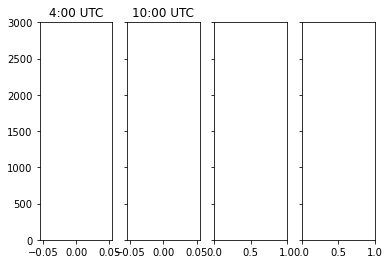

In [39]:
# Define local directory
local_dir = '/Volumes/UBL Data/data/amdar'
# Define date of interest
date = '2015-08-05'
# Define airport (Newark Liberty International defined here)
airport = ['LGA']
# Acquire data for the given day
xr_data = acars_data_download(local_dir, date, airport, delete_files=False)

# Plot data
hours, param = [4, 10, 16, 22], 'relative_humidity'
fig, ax = plt.subplots(ncols=len(hours), sharey=True)
for i, hour in enumerate(hours):
    hourly_mean, hourly_std = [xr_data[param].groupby('time.hour').mean().isel(hour=hour), 
                               xr_data[param].groupby('time.hour').std().isel(hour=hour)]
    mask = ~np.isnan(hourly_mean.values)
    hourly_mean, hourly_std = hourly_mean[mask], hourly_std[mask]
    im_mean = ax[i].plot(hourly_mean, hourly_mean.height, marker='o', lw=0)
    ax[i].set_ylim([0, 3000])
    ax[i].set_title('{0}:00 UTC'.format(hour))
fig.tight_layout()

In [31]:
sorted(['profileTime', 'profileAirport', 'nLevels', 'profileType', 'dataSource', 'latitude', 'longitude', 'wmoStaNum', 'elevation', 'en_tailNumber', 'locationName', 'trackLat', 'trackLatDD', 'trackLatQCA', 'trackLatQCR', 'trackLatQCD', 'trackLon', 'trackLonDD', 'trackLonQCA', 'trackLonQCR', 'trackLonQCD', 'altitude', 'altitudeDD', 'altitudeQCA', 'altitudeQCR', 'altitudeQCD', 'temperature', 'temperatureDD', 'temperatureQCA', 'temperatureQCR', 'temperatureQCD', 'temperatureICA', 'temperatureICR', 'windDir', 'windDirDD', 'windDirQCA', 'windDirQCR', 'windDirQCD', 'windSpeed', 'windSpeedDD', 'windSpeedQCA', 'windSpeedQCR', 'windSpeedQCD', 'dewpoint', 'dewpointDD', 'dewpointQCA', 'dewpointQCR', 'dewpointQCD', 'dewpointICA', 'dewpointICR', 'medEDR', 'medEDRDD', 'medEDRQCA', 'medEDRQCR', 'medEDRQCD', 'maxEDR', 'maxEDRDD', 'maxEDRQCA', 'maxEDRQCR', 'maxEDRQCD', 'icingCondition', 'icingConditionDD', 'icingConditionQCA', 'icingConditionQCR', 'icingConditionQCD', 'rollQuality', 'mixRatioQuality', 'relHumidity', 'obsTimeOfDay', 'turbIndex', 'turbIndexDD', 'turbIndexQCA', 'turbIndexQCR', 'turbIndexQCD', 'rhUncertainty', 'sensor1RelativeHumidity', 'sensor2RelativeHumidity', 'dewpointUncertainty', 'GPSaltitude', 'baroAltitude', 'nStaticIds', 'staticIds', 'lastRecord', 'invTime', 'prevRecord', 'inventory', 'globalInventory', 'firstOverflow', 'isOverflow', 'firstInBin', 'lastInBin', 'QCT', 'ICT', 'tamdarCarrier', 'tamdarAcType', 'filterSetNum', 'wvssTest1'])

['GPSaltitude',
 'ICT',
 'QCT',
 'altitude',
 'altitudeDD',
 'altitudeQCA',
 'altitudeQCD',
 'altitudeQCR',
 'baroAltitude',
 'dataSource',
 'dewpoint',
 'dewpointDD',
 'dewpointICA',
 'dewpointICR',
 'dewpointQCA',
 'dewpointQCD',
 'dewpointQCR',
 'dewpointUncertainty',
 'elevation',
 'en_tailNumber',
 'filterSetNum',
 'firstInBin',
 'firstOverflow',
 'globalInventory',
 'icingCondition',
 'icingConditionDD',
 'icingConditionQCA',
 'icingConditionQCD',
 'icingConditionQCR',
 'invTime',
 'inventory',
 'isOverflow',
 'lastInBin',
 'lastRecord',
 'latitude',
 'locationName',
 'longitude',
 'maxEDR',
 'maxEDRDD',
 'maxEDRQCA',
 'maxEDRQCD',
 'maxEDRQCR',
 'medEDR',
 'medEDRDD',
 'medEDRQCA',
 'medEDRQCD',
 'medEDRQCR',
 'mixRatioQuality',
 'nLevels',
 'nStaticIds',
 'obsTimeOfDay',
 'prevRecord',
 'profileAirport',
 'profileTime',
 'profileType',
 'relHumidity',
 'rhUncertainty',
 'rollQuality',
 'sensor1RelativeHumidity',
 'sensor2RelativeHumidity',
 'staticIds',
 'tamdarAcType',
 'tamda

In [66]:
fpath = '/Users/gabriel/Downloads/20210601_0000.gz'
g = gzip.open(fpath)
g_data = g.read()
x_data = xr.open_dataset(g_data)

In [72]:
x_data['relHumidity'].count()

<xarray.DataArray 'relHumidity' ()>
array(818)